File data/ecorp_price.csv provides the daily equity price of E-Corp from January 1 through December 31.  This price-equity curve contains several continuous price drops: sequences between a local price maximum and a subsequent local price minimum in which the price is either falling or staying fixed. The magnitude of a price drop is the difference in the price at the local maximum minus the price at the local minimum.  

- Write an algorithm to identify a) the magnitudes of the two largest price drops and b) the start and end dates of these two price drop sequences.
- Discuss the time complexity of your algorithm.  
- Are there any ways your algorithm might be improved?

,price
0,684.000000
1,701.880159
2,719.760318
3,731.947946
4,727.894290


Text(0, 0.5, 'Price ($)')

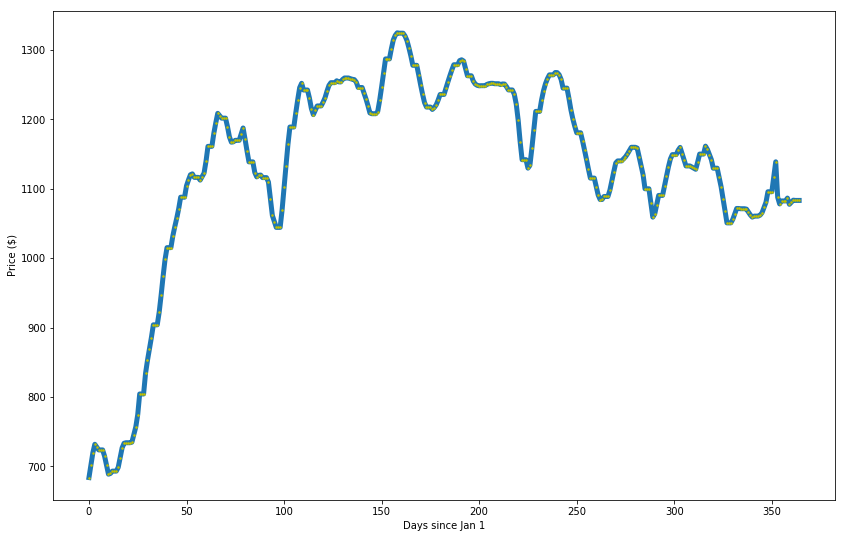

In [1]:
import pandas as pd
from IPython.display import display

import matplotlib.pyplot as plt
%matplotlib inline

ecorp = pd.read_csv("data/ecorp_price.csv")

display(ecorp.head())

plt.figure(figsize=(14,9))
plt.plot(ecorp.index,ecorp.price,ls='-', lw=5, marker='.', ms=3, mec='y', mfc='y')
plt.xlabel('Days since Jan 1')
plt.ylabel('Price ($)')

### Q1 - Algorithm
- Write an algorithm to identify a) the magnitudes of the two largest price drops and b) the start and end dates of these two price drop sequences.

In [2]:
import numpy as np

In [3]:
df=ecorp.copy()
df['Shift-1']=df['price'].shift(1)
df['Shift+1']=df['price'].shift(-1)
df['Date']=df.index
df['Mark']=''
df['Peak']=''
df['Bot']=''
df.head(3)

,price,Shift-1,Shift+1,Date,Mark,Peak,Bot
0,684.000000,NaN,701.880159,0,,,
1,701.880159,684.000000,719.760318,1,,,
2,719.760318,701.880159,731.947946,2,,,


In [4]:
# For flat tops, we want to mark the last date before the price drop begins (start of the drop)
# for flat bots, we want to mark the first date after the price flatten out (end of the drop)

for i in range(1,len(df['price'])-1):
    bef=df.at[i-1,'price']
    current=df.at[i,'price']
    nxt=df.at[i+1,'price']
    if current!=bef and current==nxt:
        df.at[i,'Mark']='F'
    elif (current==bef) & (current==nxt):
        df.at[i,'Mark']='M'
    elif (current==bef) & (current!=nxt):
        df.at[i,'Mark']='L'

In [5]:
peak_df=df.loc[(df['Mark']!='M') & (df['Mark']!='F')]
bot_df=df.loc[(df['Mark']!='M') & (df['Mark']!='L')]

In [6]:
peak_df.loc[(peak_df['price']>peak_df.shift(1)['price']) & (peak_df['price']>peak_df.shift(-1)['price']),'Peak']='P'
bot_df.loc[(bot_df['price']<bot_df.shift(1)['price']) & (bot_df['price']<bot_df.shift(-1)['price']),'Bot']='B'

d:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [7]:
# Label the local Max/Min with 'P'/'B'
df=pd.merge(df[['price','Date','Mark']],peak_df[['Date','Peak']],how='left',on='Date').fillna('')
df=pd.merge(df[['price','Date','Mark','Peak']],bot_df[['Date','Bot']],how='left',on='Date').fillna('')

In [8]:
# Let's only work with the date when hitting peak or bot
check=df.loc[(df['Peak']=='P') | (df['Bot']=='B')]
check.head(3)

,price,Date,Mark,Peak,Bot
3,731.947946,3,,P,
10,688.840638,10,,,B
53,1121.507229,53,,P,


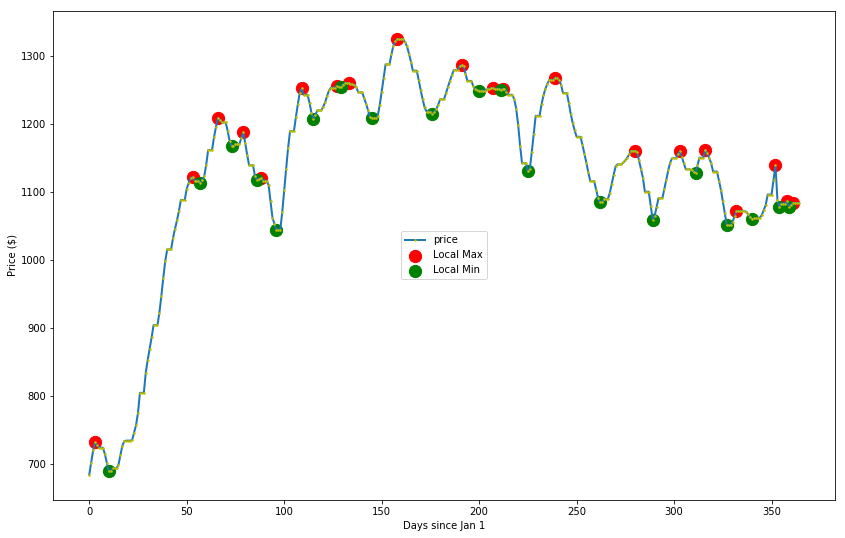

In [9]:
# Take a look at the local max/min
plt.figure(figsize=(14,9))
plt.plot(df.Date,df.price,ls='-', lw=2, marker='.', ms=3, mec='y', mfc='y')
plt.scatter(check.loc[check.Peak=='P']['Date'],check.loc[check.Peak=='P']['price'],marker='o',s=150, color='red',label='Local Max')
plt.scatter(check.loc[check.Bot=='B']['Date'],check.loc[check.Bot=='B']['price'],marker='o',s=150, color='green',label='Local Min')
plt.xlabel('Days since Jan 1')
plt.ylabel('Price ($)')
plt.legend(loc='center')
plt.show()

In [10]:
# Pair Local max with local min to calculate the price drops
cs=check.shift(-1)
cs['JoinDate']=cs.index
c=pd.merge(left=check,right=cs,left_on='Date',right_on='JoinDate')
c['Price Drop']=c.price_y-c.price_x
temp=c.sort_values(by=['Price Drop'])[['Date_x','Date_y','Price Drop']]
result=temp.rename(columns={'Date_x':'Start Date','Date_y':'End Date'})

# Top Two Largest Drops
final=result[0:2]
print('The two largest price drop are:')
final

The two largest price drop are:


,Start Date,End Date,Price Drop
24,239,262.0,-183.065628
22,212,225.0,-121.299329


### Q2 - Discuss the time complexity of your algorithm.
- The above algorithm have several linear loop over the data, hence the complexity is O(n)

### Q3 - Are there any ways your algorithm might be improved?
- We can use functions from Scipy Library (example below) to find out local max/min.
    - from scipy.signal import argrelextrema
    - from scipy.signal import find_peaks
- If we use argrelextrema we need to accept minor error for flat tops, the Start date of the price drop could be a few days before the actual drop happen. (argrelextrema always return the first date of the flat top instead of the last date). There is no such error for flat bot.

Alternatively
- We can deliberately 'over-train' a linear regression model on this data at 100% fit (0% error).
- And then use the derivative of the result function to obtain local max/min